# Variational Quantum Eigensolver

## Background

[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing the utility of quantum computation on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.  Given that size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem specific information to define the structure of the ansatz circuit.


Executing a VQE algorithm requires the following 3 components:

   1. Hamiltonian and ansatz (problem specification)
   2. Qiskit Runtime estimator
   3. Classical optimizer
   
Although the Hamiltonian and ansatz require domain specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner. 

## Setup

Here we import the tools needed for a VQE experiment.  The primary imports can be grouped logically into three components that correspond to the three required elements.

In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [8]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibmq_jakarta'

## Map the problem to a quantum-native format

Here we define the problem instance for our VQE algorithm. Although the problem in question can come from a variety of domains, the form for execution through Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the [`qiskit.circuit.library`](https://docs.quantum-computing.ibm.com/api/qiskit/circuit_library).

Here, our example Hamiltonian is derived from a quantum chemistry problem

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

Our choice of ansatz is the `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

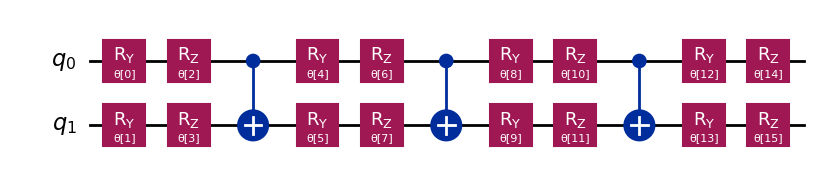

In [37]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style='iqx')

From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:

In [9]:
num_params = ansatz.num_parameters
num_params

16

## Optimize the circuits and operators

In [48]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, ConstrainedReschedule
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target), 
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment)
    ]
)

ansatz_ibm = pm.run(ansatz)

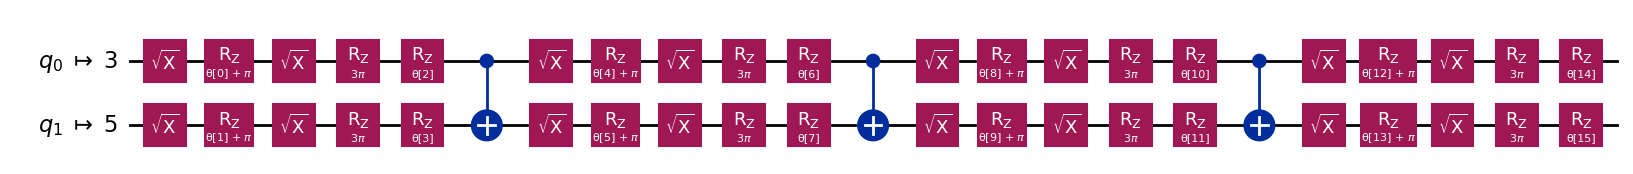

In [49]:
ansatz_ibm.draw(output='mpl', idle_wires=False, style='iqx')

## Execute using a quantum primitive function

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Qiskit Runtime [`Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator) directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple:

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function.

### Creating a callback function

Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm.  The standard SciPy callback routine allows for returning only the interim vector at each iteration.  However, it is possible to do much more than this.  Here we show how to use a mutable object, such as a dictionary, to store the current vector at each iteration, for example in case we need to restart the routine due to failure, and also return the current iteration number and average time per iteration.

In [15]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = estimator.run(ansatz, hamiltonian,
                                     parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


In [29]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

We are now free to use a classical optimizer of our choice to minimize our cost function. Here we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that, when running on real quantum hardware, the choice of optimizer is important as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, we start by specifying a random initial set of parameters:

In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)


Because we are sending a large number of jobs that we would like to execute together, here we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.

In [30]:
# Run on IBM Quantum hardware
from qiskit_ibm_runtime import Estimator, Session

with Session(backend=backend):
    estimator = Estimator(options={"shots": int(1e4)})
    callback = build_callback(ansatz_ibm, hamiltonian, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_ibm, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
    )

# Run on local simulator
# from qiskit.primitives import Estimator

# estimator = Estimator(options={"shots": int(1e4)})
# callback = build_callback(ansatz_ibm, hamiltonian, estimator, callback_dict)
# res = minimize(
#     cost_func,
#     x0,
#     args=(ansatz_ibm, hamiltonian, estimator),
#     method="cobyla",
#     callback=callback,
# )

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.

In [31]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7023489167808386
       x: [ 6.120e+00  7.614e+00 ...  3.372e+00  7.408e-01]
    nfev: 174
   maxcv: 0.0

## Analyze the results

If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `callback_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.  This is easy to verify:

In [32]:
all(callback_dict["prev_vector"] == res.x)

True

In [33]:
callback_dict["iters"] == res.nfev

True

We can also now view the progress towards convergence as monitored by the cost history at each iteration:

Text(0, 0.5, 'Cost')

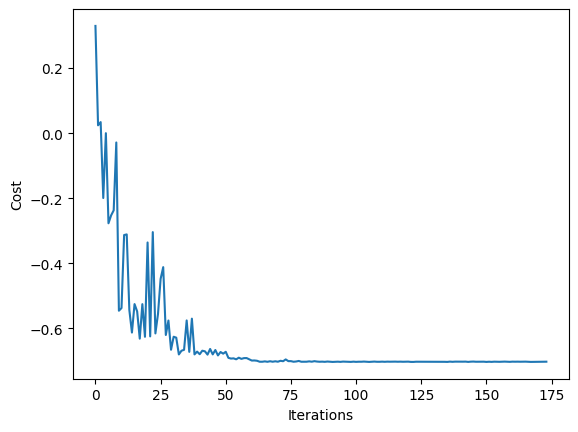

In [34]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [21]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.11.3'

In [22]:
import qiskit

qiskit.version.get_version_info()

'0.25.0'